# Compound Treats Disease Edge Prediction

This notebook is designed to take the next step moving from predicted sentences to edge predictions. After training the discriminator model, each sentences contains a confidence score for the likelihood of mentioning a relationship. Multiple relationships contain multiple sentences, which makes establishing an edge unintuitive. Is taking the max score appropiate for determining existence of an edge? Does taking the mean of each relationship make more sense? The answer towards these questions are shown below.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

In [2]:
total_candidates_df = (
    pd
    .read_csv("../dataset_statistics/results/all_ctd_map.tsv.xz", sep="\t")
    .sort_values("candidate_id")
)
total_candidates_df.head(2)

/home/danich1/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,doid_id,doid_name,resource,resource_id,drugbank_id,drug_name,disease,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
795720,DOID:1826,epilepsy syndrome,EFO,474,DB00313,Valproic Acid,epilepsy syndrome,pharmacotherapydb,1,9402,1,0.44093,9,1.0,1.0,0.0,686471,The rectal route of administration was effecti...,20,65851
828935,DOID:1826,epilepsy syndrome,EFO,474,DB01068,Clonazepam,epilepsy syndrome,pharmacotherapydb,1,937,1,0.61045,9,1.0,2.0,0.0,87832,Since the clinical data have been equivocal in...,40,65854


In [3]:
sentence_prediction_df = (
    pd
    .read_csv("input/all_predicted_ctd_sentences.tsv.xz", sep="\t")
    .sort_values("candidate_id")
)
sentence_prediction_df.head(2)

,candidate_id,pred
650175,65851,0.963179
562154,65854,0.492458


In [4]:
# DataFrame that combines likelihood scores with each candidate sentence
total_candidates_pred_df = (
    total_candidates_df[[
    "doid_id", "doid_name", 
    "drugbank_id", "drug_name", 
    "text", "hetionet",
    "candidate_id", "split"
    ]]
    .merge(sentence_prediction_df, on="candidate_id")
)

total_candidates_pred_df.to_csv(
    "output/combined_predicted_ctd_sentences.tsv.xz", 
    sep="\t", index=False, compression="xz"
)

total_candidates_pred_df.head(2)

,doid_id,doid_name,drugbank_id,drug_name,text,hetionet,candidate_id,split,pred
0,DOID:1826,epilepsy syndrome,DB00313,Valproic Acid,The rectal route of administration was effecti...,1,65851,9,0.963179
1,DOID:1826,epilepsy syndrome,DB01068,Clonazepam,Since the clinical data have been equivocal in...,1,65854,9,0.492458


In [5]:
# DataFrame that groups disease and compound mentions together and takes
# the max, median and mean of each group
grouped_candidates_pred_df=(
    total_candidates_pred_df
    .groupby(["doid_id", "drugbank_id"], as_index=False)
    .agg({
        "pred": ['max', 'mean', 'median'], 
        'hetionet': 'max',
        "drug_name": 'first',
        "doid_name": 'first',
        "split": 'first'
    })
)
grouped_candidates_pred_df.head(2)

doid_id drugbank_id      pred                     hetionet  \
                                  max      mean    median      max   
0  DOID:0050156     DB00104  0.691620  0.691620  0.691620        0   
1  DOID:0050156     DB00129  0.310866  0.259353  0.235935        0   

     drug_name                      doid_name split  
         first                          first first  
0   Octreotide  idiopathic pulmonary fibrosis     9  
1  L-Ornithine  idiopathic pulmonary fibrosis     9

In [6]:
grouped_candidates_pred_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'drug_name', 'doid_name', 'split'] else col[0] 
    for col in grouped_candidates_pred_df.columns.values
]

grouped_candidates_pred_df.head(2)

,doid_id,drugbank_id,pred_max,pred_mean,pred_median,hetionet,drug_name,doid_name,split
0,DOID:0050156,DB00104,0.691620,0.691620,0.691620,0,Octreotide,idiopathic pulmonary fibrosis,9
1,DOID:0050156,DB00129,0.310866,0.259353,0.235935,0,L-Ornithine,idiopathic pulmonary fibrosis,9


In [7]:
grouped_candidates_pred_subset_df = (
    grouped_candidates_pred_df
    .query("split==11")
    .drop("split", axis=1)
)
grouped_candidates_pred_subset_df.head(2)

,doid_id,drugbank_id,pred_max,pred_mean,pred_median,hetionet,drug_name,doid_name
56,DOID:0050156,DB01708,0.303522,0.247713,0.247492,0,Dehydroepiandrosterone,idiopathic pulmonary fibrosis
149,DOID:0050741,DB00145,0.641047,0.641047,0.641047,0,Glycine,alcohol dependence


In [8]:
grouped_candidates_pred_subset_df.hetionet.value_counts()

0    440
1      7
Name: hetionet, dtype: int64

# Best Sentence Representation Metric

This section aims to answer the question: What metric (Mean, Max, Median) best predicts Hetionet Edges?

In [9]:
performance_map = {}

In [10]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_max,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_max,
)

performance_map['max'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [11]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_mean,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_mean,
)

performance_map['mean'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [12]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_median,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subset_df.hetionet, 
    grouped_candidates_pred_subset_df.pred_median,
)

performance_map['median'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

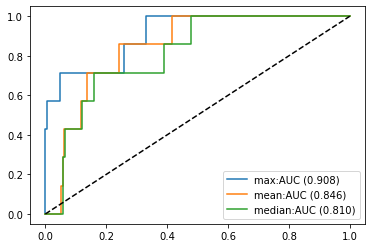

In [13]:
for key in performance_map:
    plt.plot(
        performance_map[key]['false_pos'], 
        performance_map[key]['true_pos'], 
        label=f"{key}:AUC ({auc(performance_map[key]['false_pos'], performance_map[key]['true_pos']):.3f})"
    )
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.legend()
plt.show()

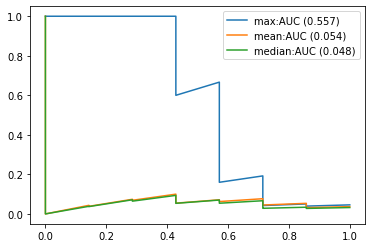

In [14]:
for key in performance_map:
    plt.plot(
        performance_map[key]['recall'], 
        performance_map[key]['precision'], 
        label=f"{key}:AUC ({auc(performance_map[key]['recall'], performance_map[key]['precision']):.3f})"
    )

plt.legend()
plt.show()

# Optimal Cutoff Using PR-Curve

In [15]:
threshold_df = (
    pd.DataFrame(
        list(
            zip(
                performance_map['max']['precision'], 
                performance_map['max']['recall'], 
                performance_map['max']['pr_threshold']
            )
        ),
        columns=["precision", "recall", "pr_threshold"]
    )
    .sort_values("precision", ascending=False)
)
threshold_df.head(2)

,precision,recall,pr_threshold
152,1.0,0.142857,0.985271
151,1.0,0.285714,0.983058


In [16]:
#precision_thresholds = pd.np.linspace(0,1,num=5)
precision_thresholds = threshold_df.round(2).drop_duplicates("precision").precision.values

# Add the lowest precision rather than
# Keep it zero
precision_thresholds = (
    pd.np.where(
        precision_thresholds==0, 
        threshold_df.precision.min(), 
        precision_thresholds
    )
)

performance_records = []
for precision_cutoff in precision_thresholds:

    cutoff = (
        threshold_df
        .query("precision>=@precision_cutoff")
        .pr_threshold
        .min()
    )
    
    values_added = (
        grouped_candidates_pred_subset_df
        .query("pred_max >= @cutoff")
        .hetionet
        .value_counts()
    )
    
    series_keys = list(values_added.keys())
    for key in series_keys:
        performance_records.append(
           {  
               "edges": values_added[key], 
               "in_hetionet": "Existing" if key == 1 else "Novel", 
               "precision": precision_cutoff,
               "sen_cutoff": cutoff
           }
        )
   
    
edges_added_df = (
    pd
    .DataFrame
    .from_records(performance_records)
)
edges_added_df.head(10)

,edges,in_hetionet,precision,sen_cutoff
0,3,Existing,1.00,0.982641
1,3,Existing,0.75,0.981844
2,1,Novel,0.75,0.981844
3,3,Existing,0.67,0.981844
4,1,Novel,0.67,0.981844
5,4,Existing,0.60,0.976413
6,2,Novel,0.60,0.976413
7,4,Existing,0.57,0.975945
8,3,Novel,0.57,0.975945
9,4,Existing,0.50,0.974425


[None]

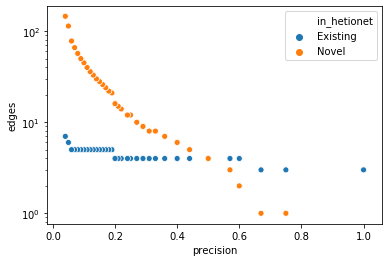

In [17]:
ax = sns.scatterplot(x="precision", y="edges", hue="in_hetionet", data=edges_added_df)
ax.set(yscale="log")

In [18]:
edges_added_df.to_csv("output/precision_ctd_edges_added.tsv", index=False, sep="\t")

# Total Recalled Edges

How many edges of hetionet can we recall using a cutoff score of 0.5?

In [19]:
datarows = []
datarows.append({
    "recall":(
        grouped_candidates_pred_df
        .query("pred_max > 0.5")
        .hetionet
        .value_counts()[1] /
        grouped_candidates_pred_df
        .hetionet.
        value_counts()[1]
    ),
    "edges":(
        grouped_candidates_pred_df
        .query("pred_max > 0.5")
        .hetionet
        .value_counts()[1]
    ),
    "in_hetionet": "Existing",
    "total": int(grouped_candidates_pred_df.hetionet.value_counts()[1]),
    "relation":"CtD"
})
datarows.append({
    "edges":(
        grouped_candidates_pred_df
        .query("pred_max > 0.5")
        .hetionet
        .value_counts()[0]
    ),
    "in_hetionet": "Novel",
    "relation":"CtD"
})
edges_df = pd.DataFrame.from_records(datarows)
edges_df

,edges,in_hetionet,recall,relation,total
0,425,Existing,0.974771,CtD,436.0
1,11404,Novel,NaN,CtD,NaN


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


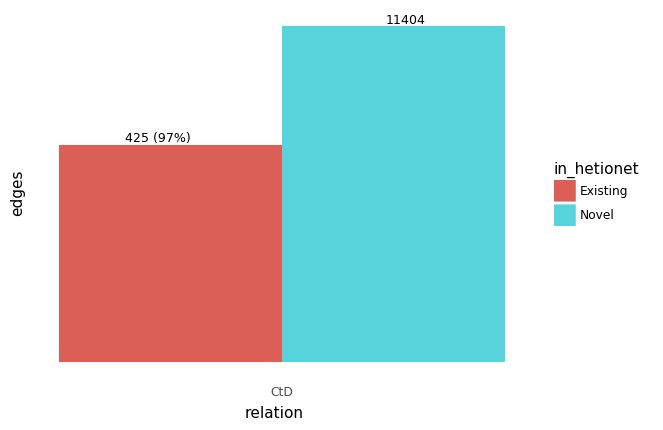

<ggplot: (8792932623922)>


In [20]:
import math
g = (
    p9.ggplot(edges_df, p9.aes(x="relation", y="edges", fill="in_hetionet"))
    + p9.geom_col(position="dodge")
    + p9.geom_text(
        p9.aes(
            label=(
                edges_df
                .apply(
                    lambda x: 
                    f"{x['edges']} ({x['recall']*100:.0f}%)" 
                    if not math.isnan(x['recall']) else 
                    f"{x['edges']}",
                    axis=1
                )
            )
        ),
        position=p9.position_dodge(width=1),
        size=9,
        va="bottom"
    )
    + p9.scale_y_log10()
    + p9.theme(
        axis_text_y=p9.element_blank(),
        axis_ticks_major = p9.element_blank(),
        rect=p9.element_blank()
    )
)
print(g)